<center><h1> Week 2: Multilayer Perceptrons and Stochastic Gradient Descent </h1></center>
<center> Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>
    <center>  </center>

This notebook is inspired by the [D2L book](https://d2l.ai/) and adapted from lecture material created by Krishna Pillutla.

In [1]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time
import copy

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

## Part 0: PyTorch Preliminaries
PyTorch's automatic differentiation works by building a 
"computation graph" of all operations on tensors with `requires_grad=True`. 
It then computes the requested gradients by performing 
reverse-mode automatic differentiation, a.k.a. backpropagation. 

![Computational graph](https://upload.wikimedia.org/wikipedia/commons/a/a0/ReverseaccumulationAD.png)

There are number of caveats to keep in mind:

- Automatic differentiation only works for floating point types (float32, float64). It does not work for integer types. (Think about why this is the case).
- "Building a computation graph" takes up space. The memory usage increases proportional to the number of intermediate quantities stored.

There are number of operations one might want to perform without building a computational graph. Examples include:

- SGD updates
- Accuracy computation (in general, logging utilies)

PyTorch allows you to "hide" computations from autograd using
`torch.no_grad()` (for example, see the accuracy computation functions below).

### Part 0.1: Automatic Differentiation Practice

Use PyTorch's automatic differentiation routines to compute the following derivatives/gradients and verify them on sample inputs. The solution to the first one is provided as an example.

1. $f : \mathbb{R}^3 \to \mathbb{R}$ defined by $f(x) = \|x\| = \sqrt{x_1^2 + x_2^2 + x_3^2}$. Find $\nabla_x f(x)$ for some $x\neq 0$ (note that $f$ is not differentiable at $0$).
1. $g: \mathbb{R}^3 \to \mathbb{R}$ defined by $g(y) = \frac{\exp(y_1)}{\exp(y_1) + \exp(y_2) + \exp(y_3)}$. Find $\nabla_y g(y)$.
1. $h: \mathbb{R}^2 \times \mathbb{R}^3 \to \mathbb{R}$ with $h(a, b) = a^\top M b$ and $M\in \mathbb{R}^{2 \times 3}$ is the matrix of all ones (i.e., $M_{ij}=1$ for each $i, j$). Find $\nabla_a h(a, b)$ and $\nabla_b h(a, b)$.

In [3]:
## Solution to Part 1 in two ways:
x = torch.randn(3, requires_grad=True)
true_gradient = x / torch.norm(x)  # computed analytically for verification

# (a) Using the `.backward()` call
output = torch.norm(x)
output.backward()
gradient = x.grad 
print(x, gradient, true_gradient)

# (b) Using the `torch.autograd.grad` call
output = torch.norm(x)
# `torch.autograd.grad` returns a list. It has only one entry in this example
gradient = torch.autograd.grad(outputs=output, inputs=[x])[0]
print(x, gradient, true_gradient)

## Solution to Part 2
# <Your code here>
y = torch.randn(3, requires_grad=True)
output = torch.exp(y[0])/torch.sum(torch.exp(y))
output.backward()
gradient = y.grad
print(y, gradient)

## Solution to Part 3
# <Your code here>
M = torch.ones(2, 3, requires_grad=False)
a = torch.randn(2, requires_grad=True)
b = torch.randn(3, requires_grad=True)

output = torch.dot(a, torch.matmul(M,b))
gradient = torch.autograd.grad(outputs=output, inputs=[a,b])
print(a,b,gradient)

tensor([ 0.1820, -0.8567,  1.1006], requires_grad=True) tensor([ 0.1294, -0.6091,  0.7825]) tensor([ 0.1294, -0.6091,  0.7825], grad_fn=<DivBackward0>)
tensor([ 0.1820, -0.8567,  1.1006], requires_grad=True) tensor([ 0.1294, -0.6091,  0.7825]) tensor([ 0.1294, -0.6091,  0.7825], grad_fn=<DivBackward0>)
tensor([-1.0712,  0.1227, -0.5663], requires_grad=True) tensor([ 0.1397, -0.0930, -0.0467])
tensor([ 0.3731, -0.8920], requires_grad=True) tensor([-1.5091,  0.3704,  1.4565], requires_grad=True) (tensor([0.3178, 0.3178]), tensor([-0.5189, -0.5189, -0.5189]))


Let us now generalize these examples to high dimensions.

1. $f : \mathbb{R}^n \to \mathbb{R}$ defined by $f(x) = \|x\| = \sqrt{\sum_{j=1}^n x_j^2}$. Find $\nabla_x f(x)$ for some $x\neq 0$ (note that $f$ is not differentiable at $0$).
1. $g: \mathbb{R}^3 \to \mathbb{R}$ defined by $g(y) = \exp(y_1)/\sum_{k=1}^n \exp(y_k)$. Find $\nabla_y g(y)$.
1. $h: \mathbb{R}^m \times \mathbb{R}^n \to \mathbb{R}$ with $h(a, b) = a^\top M b$ and $M\in \mathbb{R}^{m \times n}$ is the matrix of all ones (i.e., $M_{ij}=1$ for each $i\in[m],j\in[n]$). Find $\nabla_a h(a, b)$ and $\nabla_b h(a, b)$.

For these examples, you may take $n = 100$ and $m = 50$.

In [ ]:
## Solution to Part 1 
# <Your code here>

## Solution to Part 2
# <Your code here>

## Solution to Part 3
# <Your code here>

## Part 1: SGD for logistic regression versus the learning rate

We will run SGD on the same fashion MNIST dataset as in the demo. Our goal here is to study the effect of the learning rate on the train/test loss/accuracy.

Your task is to fill in the SGD update (look for `# <Your code here>`) and make the requested plots.

In [4]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]


print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


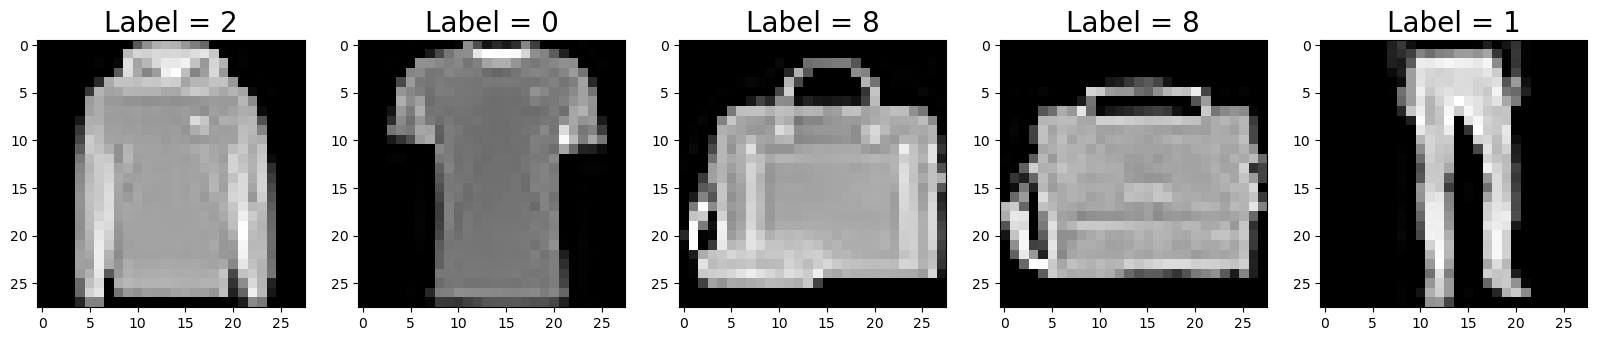

In [5]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

In [6]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [7]:
# Some utility functions to compute the objective and the accuracy
def compute_objective(w, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        Require w of shape (d,K), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * torch.norm(w)**2
    )

@torch.no_grad()
def compute_accuracy(w, X, y):
    """ Compute the classification accuracy
        Require w of shape (d,K), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    # <Your code here>: compute the accuracy from predictions and y
    # Return the fraction of predictions that are correct

@torch.no_grad()
def compute_logs(w, reg_param, verbose=False):
    train_loss = compute_objective(w, X_train, y_train, reg_param)
    test_loss = compute_objective(w, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(w, X_train, y_train)
    test_accuracy = compute_accuracy(w, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [10]:
def sgd_one_pass(w, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1    
        objective = compute_objective(w, X[idx:idx+1], y[idx:idx+1], reg_param) 
        
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradient = torch.autograd.grad(outputs=objective, inputs=w)[0]
        
        # perform SGD update
        with torch.no_grad():
            # <Your code here>
            
    return w

Find the divergent learning rate. 

Recall the definition of the divergent learning rate. We say 𝜂⋆ is the divergent learning rate if SGD with a learning rate of 2𝜂⋆ diverges, but SGD with a learning rate of 𝜂⋆ does not. 

Edit the code below to change the learning rate. 

*Hint 1*: Try different orders of magnitude. For instance, start with 1e-2. If it diverges, try 1e-6, if not, try 10.0. Once we establish a lower and upper bound on it, finding the divergent learning rate comes down to a binary search (on a logarithmic scale). 

*Hint 2*: A common strategy is to search in powers of 10 (as in hint 1), and then narrow the search down in powers of 2. For instance, if we end up with 1e-3 as an estimate of the divergent learning from hint 1, try out 2e-3 and 4e-3 as well in order to refine the estimate of the divergent learning rate.

**Note**: the divergent learning rate is a heuristic which gives the right ballpark figure of the learning rate. 
A learning rate that satisfies the heuristic might still result in the loss diverging, in which case we would have redo the process with half that learning rate.

In [8]:
learning_rate = 1.0
reg_param = 0.0

w = torch.zeros(784, n_class, requires_grad=True)
_ = compute_logs(w, reg_param, verbose=True)


w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(w, reg_param, verbose=True)


AttributeError: 'NoneType' object has no attribute 'item'

Now complete the following function which runs SGD for some number of passes through the data and tracks the test accuracy at the end of each pass. 

In [ ]:
# Note: X_train, y_train, X_test, y_test are global variables
def run_sgd(w, reg_param, learning_rate, num_passes=20, verbose=True):
    logs = []

    log_statistics = # <Your code here>; 
    #call `compute_logs` and track the train/test loss/accuracy
    logs.append(log_statistics)
    for j in range(num_passes):
        # <Your code here>. Hint: call sgd_one_pass
        log_statistics = # <Your code here>; 
        #call `compute_logs` and track the train/test loss/accuracy
        logs.append(log_statistics)
    return w, logs

Run SGD for the learning rates from the list `[1e-2, 1e-3, 1e-4, 1e-5]` for 10 epochs. 
Plot 4 curves:

 - Train loss vs number of passes,
 - Train accuracy vs number of passes,
 - Test loss vs number of passes,
 - Test accuracy vs number of passes.
 
 Each curve must contain multiple lines, each corresponding to a different learning rate. 
 You may use `reg_param=1e-3`.

In [ ]:
# <Your code here>

## Part 2: The effect of initialization and learning rate on MLPs
We will repeat the same experiment with MLPs.

Start by filling in the blank in the `sgd_one_pass` function.

In [ ]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective_mlp(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy_mlp(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs_mlp(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective_mlp(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective_mlp(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy_mlp(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy_mlp(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def sgd_one_pass_mlp(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    # Each pass through the data is called an `epoch`.
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective_mlp(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            # TODO: <Your code here>
    return ws, bs

Find the divergent learning rate. Edit the code below to change the learning rate and see what you observe. 


In [ ]:
learning_rate = 1e-2

hidden_size = 1024
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs_mlp(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs_mlp(ws, bs, reg_param, verbose=True)


Next, we will play with the initialization.

- Try initializing with every W_j, b_j be 0 everywhere. What happens?
- Try W_j, b_j be 1 everywhere. What happens?

For these two cases, compute the gradient $\nabla f(w)$. What do you observe? Does this explain why these initializations are unsuitable for stochastic gradient optimization?

- Try increasing the variance from 0 to 1e-20, 1e-10, 1e-6, 1e-3 and 1e-1. What do you observe?
- Try out the so-called Glorot-Bengio initialization scheme, where $W_j \in \mathbb{R}^{d_{j-1}\times d_j}$ is taken to be be normally distributed with variance $1/d_{j}$.

In [ ]:
learning_rate = 2.5e-3

# TODO: change the initialization
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]
_ = compute_logs(ws, bs, reg_param, verbose=True)


ws = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Next, we write a function which makes a certain number of passes of SGD.

In [ ]:
def run_sgd_mlp(ws, bs, reg_param, learning_rate, num_passes=10, verbose=True):
    logs = [compute_logs_mlp(ws, bs, reg_param, verbose=verbose)]
    # We run training for multiple epochs. Each epoch is a pass through the data.
    for j in range(num_passes):
        ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, 
                          reg_param, learning_rate, verbose=False)
        logs.append(compute_logs_mlp(ws, bs, reg_param, verbose=verbose))
    return ws, bs, np.asarray(logs)

Run SGD for the learning rates from the list `[1e-2, 1e-3, 1e-4, 1e-5]` for 10 epochs. 
Plot 4 curves:

 - Train loss vs number of passes,
 - Train accuracy vs number of passes,
 - Test loss vs number of passes,
 - Test accuracy vs number of passes.
 
 Each curve must contain multiple lines, each corresponding to a different learning rate. 
 You may use `reg_param=0`. 
 
 Note: This takes several minutes to run. It took me 15 min for everything to run.

In [ ]:
# TODO: <Your code here>